In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import normaltest
from scipy.stats import norm
import seaborn as sns
from scipy import stats
from scipy.stats import boxcox
from scipy.stats import shapiro
from scipy.stats import kstest
from statsmodels.tsa.seasonal import STL
from scipy import special

from prophet import Prophet
from prophet.plot import add_changepoints_to_plot
from prophet.plot import plot_plotly, plot_components_plotly

c:\Users\rizki\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


In [2]:
df=pd.read_csv('DataFix.csv',sep=';', decimal=',', index_col='DATE', parse_dates=True, dayfirst=True)
pd.set_option('display.float_format', '{:,.2f}'.format)
df.sort_index(inplace=True)
print(df.shape)
df.head()

(365, 1)


,VOLUME
DATE,
2022-06-01,"44,003.56"
2022-06-02,"48,991.85"
2022-06-03,"51,690.92"
2022-06-04,"47,790.83"
2022-06-05,"42,896.64"


<Axes: xlabel='DATE'>

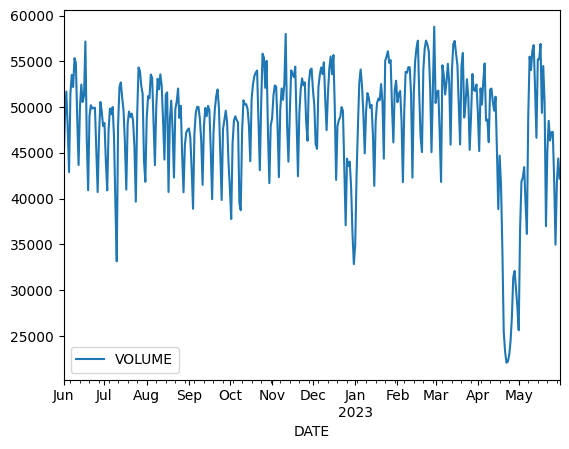

In [3]:
df.plot(y='VOLUME')

<Axes: xlabel='DATE'>

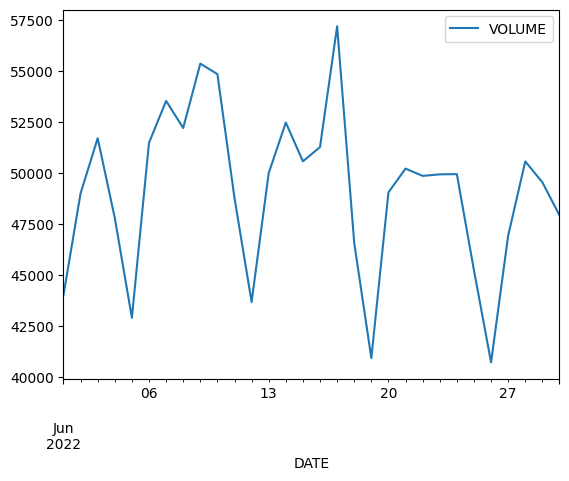

In [4]:
june_2022 = df.loc['2022-06']
june_2022.plot(y='VOLUME')

In [5]:
import numpy as np
from scipy.stats import normaltest

# Perform D'Agostino's K-squared test
k2_statistic, p_value = normaltest(df)

# Set significance level
alpha = 0.05

# Print results
print("D'Agostino's K-squared test statistic:", k2_statistic)
print("p-value:", p_value)

# Perform hypothesis test
if p_value < alpha:
    print("Reject the null hypothesis. The data does not follow a normal distribution.")
else:
    print("Fail to reject the null hypothesis. The data follows a normal distribution.")


D'Agostino's K-squared test statistic: [125.37065407]
p-value: [5.97184287e-28]
Reject the null hypothesis. The data does not follow a normal distribution.


**Detecting Sesonality and Trend**

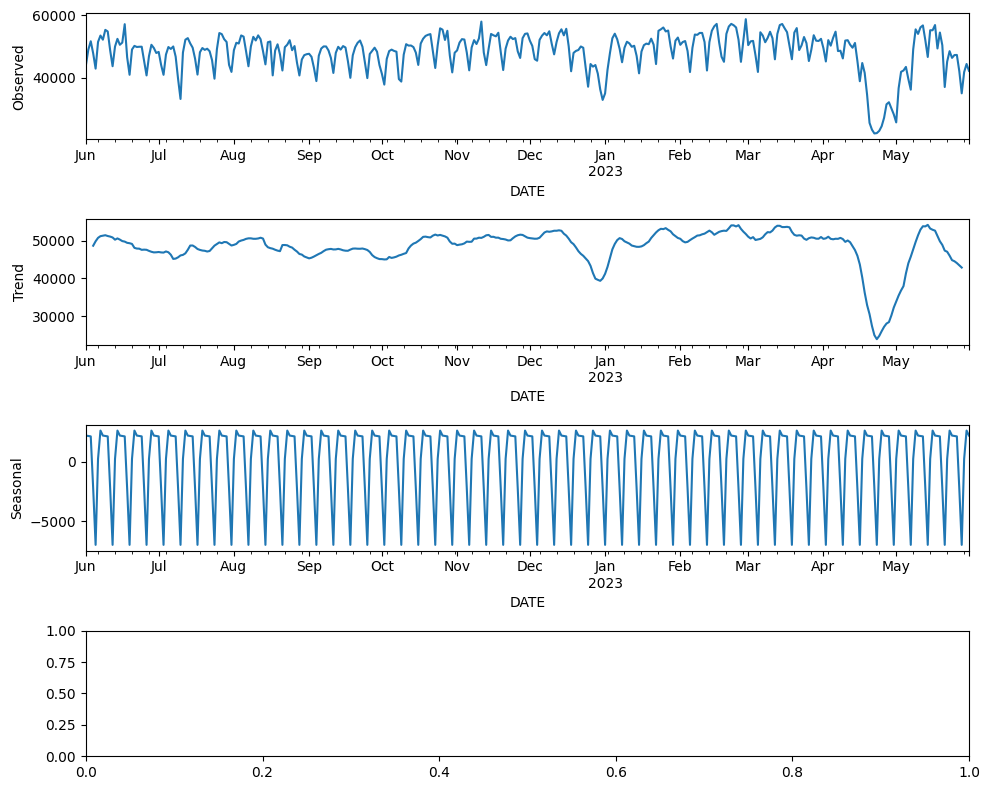

In [6]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Perform seasonal decomposition
result = seasonal_decompose(df['VOLUME'], model='additive')  # Use 'multiplicative' for non linear trend

# Plot the decomposition components
fig, axes = plt.subplots(4, 1, figsize=(10, 8))
result.observed.plot(ax=axes[0])
axes[0].set_ylabel('Observed')
result.trend.plot(ax=axes[1])
axes[1].set_ylabel('Trend')
result.seasonal.plot(ax=axes[2])
axes[2].set_ylabel('Seasonal')


plt.tight_layout()
plt.show()

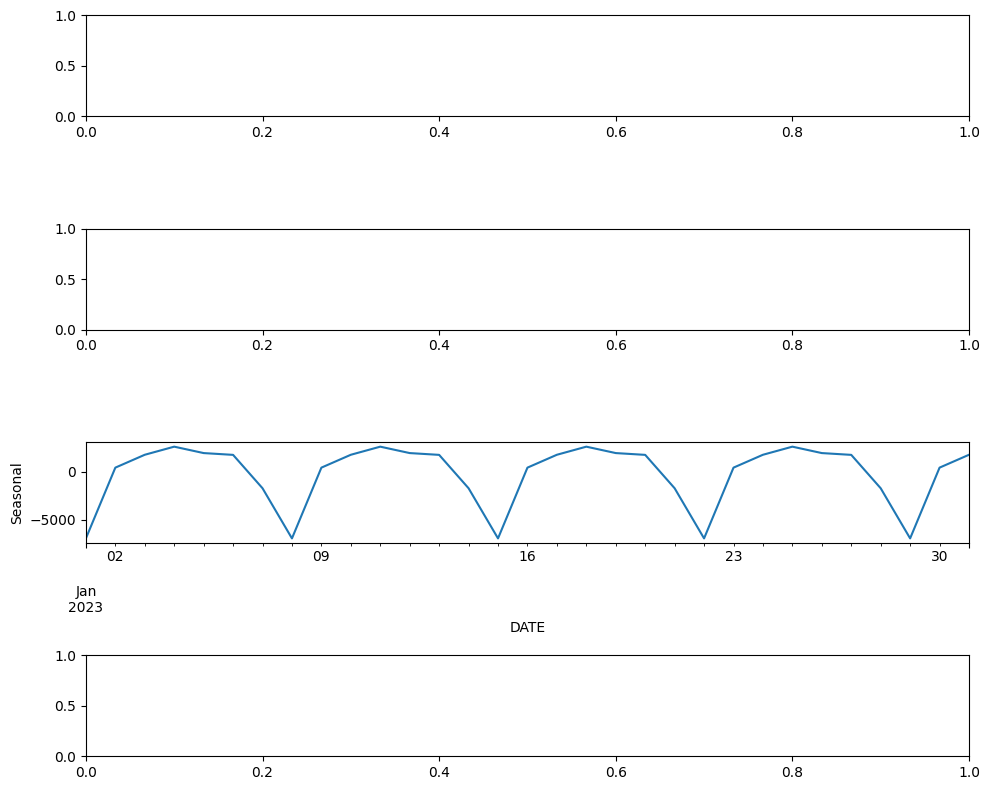

In [7]:
# Filter data for January 2023
january_2023 = df.loc['2023-01']

# Perform seasonal decomposition
result = seasonal_decompose(january_2023, model='additive')  # Use 'multiplicative' for non-linear trend

# Plot the decomposition components
fig, axes = plt.subplots(4, 1, figsize=(10, 8))
result.seasonal.plot(ax=axes[2])
axes[2].set_ylabel('Seasonal')

plt.tight_layout()
plt.show()

### Normality Test

Text(0.5, 1.0, 'Histogram of Data')

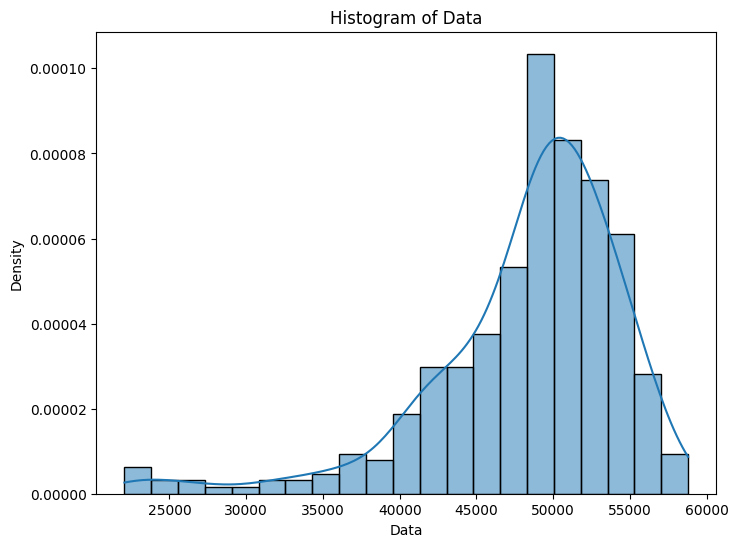

In [8]:
# Create a histogram
plt.figure(figsize=(8, 6))
sns.histplot(df['VOLUME'], kde=True, stat='density')
plt.xlabel('Data')
plt.ylabel('Density')
plt.title('Histogram of Data')




In [9]:
import numpy as np
from scipy.stats import kstest, norm

# Extract the 'VOLUME' column from the DataFrame as a NumPy array
data = df['VOLUME'].values

# Perform the KS normality test
test_statistic, p_value = kstest(data, norm.cdf)

# Set the significance level
alpha = 0.05

# Print the test statistic and p-value
print("Test Statistic:", test_statistic)
print("P-value:", p_value)

# Perform the hypothesis test
if p_value > alpha:
    print("Null hypothesis: Data is normally distributed (fail to reject H0)")
else:
    print("Alternate hypothesis: Data is not normally distributed (reject H0)")


Test Statistic: 1.0
P-value: 0.0
Alternate hypothesis: Data is not normally distributed (reject H0)


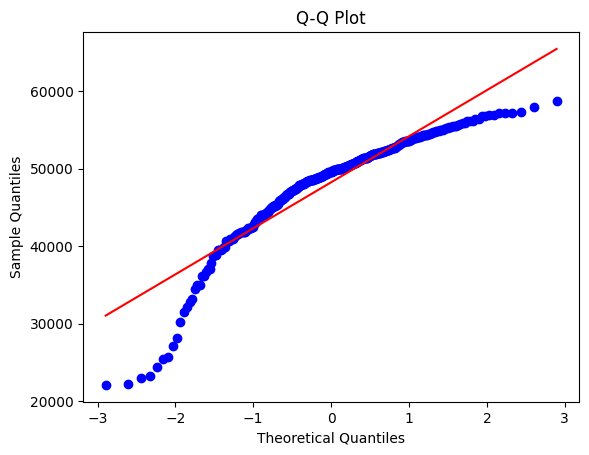

In [10]:
# Assuming your data is stored in a variable called 'data'
data = df['VOLUME']

# Create a Q-Q plot
stats.probplot(data, dist="norm", plot=plt)
plt.title("Q-Q Plot")
plt.xlabel("Theoretical Quantiles")
plt.ylabel("Sample Quantiles")
plt.show()

Box-Cox Transformation

In [11]:
# Apply Box-Cox transformation to the time series data
transformed_data, lambda_value = boxcox(df['VOLUME'])

# Create a new DataFrame with the transformed data
transformed_df = pd.DataFrame({'Transformed_Value': transformed_data}, index=df.index)

# Concatenate the original and transformed dataframes
result_df = pd.concat([df, transformed_df], axis=1)
result_df = result_df.rename(columns={'VOLUME':'Actual_Value'})

# Print the combined DataFrame
print("Lambda Value:", lambda_value)
result_df.head()

Lambda Value: 4.217336828667283


,Actual_Value,Transformed_Value
DATE,,
2022-06-01,"44,003.56","9,080,590,171,912,008,704.00"
2022-06-02,"48,991.85","14,282,154,504,148,963,328.00"
2022-06-03,"51,690.92","17,906,774,968,518,803,456.00"
2022-06-04,"47,790.83","12,862,753,426,476,957,696.00"
2022-06-05,"42,896.64","8,155,508,753,746,161,664.00"


Normality After Box-Cox Transformation

Text(0.5, 1.0, 'Histogram of Data After Transformation')

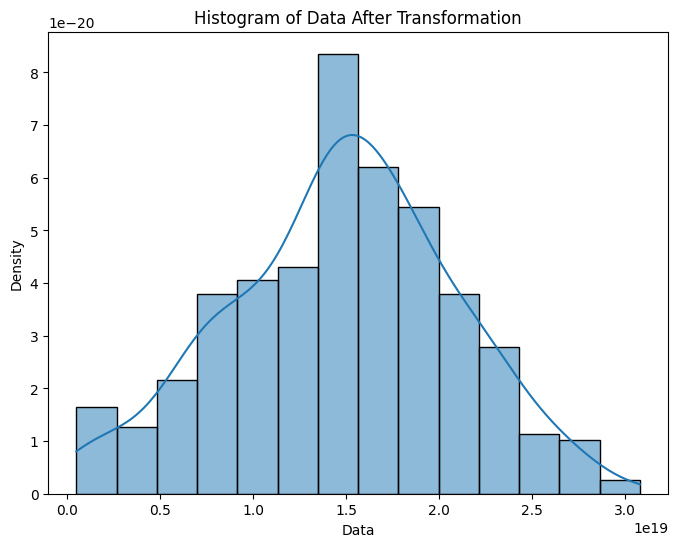

In [12]:
# Create a histogram
plt.figure(figsize=(8, 6))
sns.histplot(result_df['Transformed_Value'], kde=True, stat='density')
plt.xlabel('Data')
plt.ylabel('Density')
plt.title('Histogram of Data After Transformation')


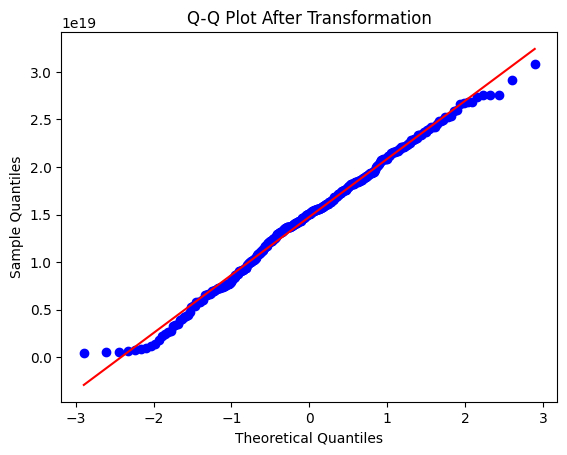

In [13]:
# Assuming your data is stored in a variable called 'data'
data = result_df['Transformed_Value']

# Create a Q-Q plot
stats.probplot(data, dist="norm", plot=plt)
plt.title("Q-Q Plot After Transformation")
plt.xlabel("Theoretical Quantiles")
plt.ylabel("Sample Quantiles")
plt.show()

In [14]:
df_transformed = result_df['Transformed_Value']
df_transformed = pd.DataFrame(df_transformed)
df_transformed.columns = ['VOLUME']
df_transformed.head()

,VOLUME
DATE,
2022-06-01,"9,080,590,171,912,008,704.00"
2022-06-02,"14,282,154,504,148,963,328.00"
2022-06-03,"17,906,774,968,518,803,456.00"
2022-06-04,"12,862,753,426,476,957,696.00"
2022-06-05,"8,155,508,753,746,161,664.00"


In [15]:
df_transformed.to_csv('Hasil_box-cox', index=True)

In [16]:
import numpy as np
from scipy.stats import normaltest

# Perform D'Agostino's K-squared test
k2_statistic, p_value = normaltest(df_transformed)

# Set significance level
alpha = 0.05

# Print results
print("D'Agostino's K-squared test statistic:", k2_statistic)
print("p-value:", p_value)

# Perform hypothesis test
if p_value < alpha:
    print("Reject the null hypothesis. The data does not follow a normal distribution.")
else:
    print("Fail to reject the null hypothesis. The data follows a normal distribution.")


D'Agostino's K-squared test statistic: [2.69153724]
p-value: [0.26033953]
Fail to reject the null hypothesis. The data follows a normal distribution.


Reverse Box_Cox

In [17]:
original_data = special.inv_boxcox(df_transformed, lambda_value)
original_data = pd.DataFrame(original_data)

# Print the original data
original_data.head()

,VOLUME
DATE,
2022-06-01,"44,003.56"
2022-06-02,"48,991.85"
2022-06-03,"51,690.92"
2022-06-04,"47,790.83"
2022-06-05,"42,896.64"


## **SARIMA**

In [18]:
from pmdarima import auto_arima
sarima1 = auto_arima(df_transformed, m=7, seasonal=True, trace=True, 
                    error_action='ignore',  
                    suppress_warnings=True, 
                    stepwise=True)

sarima1.summary()

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[7] intercept   : AIC=32209.976, Time=1.28 sec
 ARIMA(0,0,0)(0,0,0)[7] intercept   : AIC=32613.244, Time=0.03 sec
 ARIMA(1,0,0)(1,0,0)[7] intercept   : AIC=32309.217, Time=0.39 sec
 ARIMA(0,0,1)(0,0,1)[7] intercept   : AIC=33004.186, Time=0.27 sec
 ARIMA(0,0,0)(0,0,0)[7]             : AIC=33315.766, Time=0.02 sec
 ARIMA(2,0,2)(0,0,1)[7] intercept   : AIC=32318.171, Time=0.50 sec
 ARIMA(2,0,2)(1,0,0)[7] intercept   : AIC=inf, Time=1.68 sec
 ARIMA(2,0,2)(2,0,1)[7] intercept   : AIC=32210.742, Time=2.63 sec
 ARIMA(2,0,2)(1,0,2)[7] intercept   : AIC=32210.849, Time=2.21 sec
 ARIMA(2,0,2)(0,0,0)[7] intercept   : AIC=32383.543, Time=0.14 sec
 ARIMA(2,0,2)(0,0,2)[7] intercept   : AIC=inf, Time=2.35 sec
 ARIMA(2,0,2)(2,0,0)[7] intercept   : AIC=32240.242, Time=3.04 sec
 ARIMA(2,0,2)(2,0,2)[7] intercept   : AIC=32213.955, Time=3.36 sec
 ARIMA(1,0,2)(1,0,1)[7] intercept   : AIC=32205.823, Time=1.30 sec
 ARIMA(1,0,2)(0,0,1)[7] interce

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  365
Model:             SARIMAX(1, 0, 2)x(1, 0, [1], 7)   Log Likelihood              -16095.911
Date:                             Wed, 17 Jul 2024   AIC                          32203.823
Time:                                     08:39:13   BIC                          32227.222
Sample:                                 06-01-2022   HQIC                         32213.122
                                      - 05-31-2023                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9192      0.053     17.298      0.000       0.815       1.023
ma.L1         -0.2083      0.104     -2.010      0.044      -0.411      -0.005
ma.L2         -0.1365      0.129     -1.058      0.290      -0.389       0.116
ar.S.L7        0.9944      0.009    114.972      0.000       0.977       1.011
ma.S.L7       -0.8980      0.074    -12.154      0.000      -1.043      -0.753
sigma2      1.952e+37    1.2e-39   1.63e+76      0.000    1.95e+37    1.95e+37
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                75.33
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               2.14   Skew:                            -0.36
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.11
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 6.55e+91. Standard errors may be unstable.
"""

In [19]:
from pmdarima import auto_arima
sarima2 = auto_arima(df_transformed, m=7, start_q = 1, max_q =1,
                    seasonal=True, trace=True, 
                    error_action='ignore',  
                    suppress_warnings=True, 
                    stepwise=True)

sarima2.summary()

Performing stepwise search to minimize aic


 ARIMA(2,0,1)(1,0,1)[7] intercept   : AIC=32222.781, Time=1.52 sec
 ARIMA(0,0,0)(0,0,0)[7] intercept   : AIC=32613.244, Time=0.05 sec
 ARIMA(1,0,0)(1,0,0)[7] intercept   : AIC=32309.217, Time=0.26 sec
 ARIMA(0,0,1)(0,0,1)[7] intercept   : AIC=33004.186, Time=0.25 sec
 ARIMA(0,0,0)(0,0,0)[7]             : AIC=33315.766, Time=0.02 sec
 ARIMA(2,0,1)(0,0,1)[7] intercept   : AIC=32369.948, Time=0.43 sec
 ARIMA(2,0,1)(1,0,0)[7] intercept   : AIC=inf, Time=1.22 sec
 ARIMA(2,0,1)(2,0,1)[7] intercept   : AIC=32223.974, Time=1.90 sec
 ARIMA(2,0,1)(1,0,2)[7] intercept   : AIC=32224.034, Time=1.78 sec
 ARIMA(2,0,1)(0,0,0)[7] intercept   : AIC=32460.429, Time=0.21 sec
 ARIMA(2,0,1)(0,0,2)[7] intercept   : AIC=32325.492, Time=0.53 sec
 ARIMA(2,0,1)(2,0,0)[7] intercept   : AIC=32253.004, Time=2.03 sec
 ARIMA(2,0,1)(2,0,2)[7] intercept   : AIC=32226.758, Time=1.77 sec
 ARIMA(1,0,1)(1,0,1)[7] intercept   : AIC=32255.531, Time=0.43 sec
 ARIMA(2,0,0)(1,0,1)[7] intercept   : AIC=32256.326, Time=0.41 sec


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  365
Model:             SARIMAX(3, 0, 0)x(1, 0, [1], 7)   Log Likelihood              -16103.347
Date:                             Wed, 17 Jul 2024   AIC                          32218.695
Time:                                     08:39:53   BIC                          32242.094
Sample:                                 06-01-2022   HQIC                         32227.994
                                      - 05-31-2023                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7075      0.089      7.930      0.000       0.533       0.882
ar.L2         -0.0048      0.144     -0.033      0.974      -0.287       0.277
ar.L3          0.1666      0.121      1.380      0.168      -0.070       0.403
ar.S.L7        0.9928      0.010     95.508      0.000       0.972       1.013
ma.S.L7       -0.8843      0.077    -11.433      0.000      -1.036      -0.733
sigma2      2.105e+37   2.49e-39   8.44e+75      0.000    2.11e+37    2.11e+37
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                66.88
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               2.10   Skew:                            -0.33
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.99
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.3e+91. Standard errors may be unstable.
"""

In [20]:
from pmdarima import auto_arima
sarima3 = auto_arima(df_transformed, m=7, start_q= 0, start_p=0,
                    max_q = 1, max_p= 1, seasonal=True, trace=True, 
                    error_action='ignore',  
                    suppress_warnings=True, 
                    stepwise=True)

sarima3.summary()

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,0,1)[7] intercept   : AIC=32508.830, Time=1.00 sec
 ARIMA(0,0,0)(0,0,0)[7] intercept   : AIC=32613.244, Time=0.04 sec
 ARIMA(1,0,0)(1,0,0)[7] intercept   : AIC=32309.217, Time=0.34 sec
 ARIMA(0,0,1)(0,0,1)[7] intercept   : AIC=33004.186, Time=0.21 sec
 ARIMA(0,0,0)(0,0,0)[7]             : AIC=33315.766, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[7] intercept   : AIC=32467.899, Time=0.04 sec
 ARIMA(1,0,0)(2,0,0)[7] intercept   : AIC=32281.382, Time=0.64 sec
 ARIMA(1,0,0)(2,0,1)[7] intercept   : AIC=32257.724, Time=0.90 sec
 ARIMA(1,0,0)(1,0,1)[7] intercept   : AIC=32256.430, Time=0.45 sec
 ARIMA(1,0,0)(0,0,1)[7] intercept   : AIC=32378.034, Time=0.19 sec
 ARIMA(1,0,0)(1,0,2)[7] intercept   : AIC=32257.803, Time=0.87 sec
 ARIMA(1,0,0)(0,0,2)[7] intercept   : AIC=32339.399, Time=0.88 sec
 ARIMA(1,0,0)(2,0,2)[7] intercept   : AIC=32260.422, Time=0.91 sec
 ARIMA(1,0,1)(1,0,1)[7] intercept   : AIC=32255.531, Time=0.43 sec
 ARIMA(1,0,1)(0,0,1

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                  365
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 7)   Log Likelihood              -16121.766
Date:                           Wed, 17 Jul 2024   AIC                          32253.531
Time:                                   08:40:11   BIC                          32273.030
Sample:                               06-01-2022   HQIC                         32261.280
                                    - 05-31-2023                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8885      0.068     13.099      0.000       0.756       1.021
ma.L1         -0.2165      0.132     -1.644      0.100      -0.475       0.042
ar.S.L7        0.9918      0.012     83.938      0.000       0.969       1.015
ma.S.L7       -0.8755      0.086    -10.200      0.000      -1.044      -0.707
sigma2      2.457e+37   1.11e-39   2.21e+76      0.000    2.46e+37    2.46e+37
===================================================================================
Ljung-Box (L1) (Q):                   0.36   Jarque-Bera (JB):                65.11
Prob(Q):                              0.55   Prob(JB):                         0.00
Heteroskedasticity (H):               2.09   Skew:                            -0.33
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.96
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 5.24e+92. Standard errors may be unstable.
"""

In [21]:
from pmdarima import auto_arima
sarima4 = auto_arima(df_transformed, m=7, start_q= 0, start_p=0,
                    max_q = 0, max_p= 1, seasonal=True, trace=True, 
                    error_action='ignore',  
                    suppress_warnings=True, 
                    stepwise=True)

sarima4.summary()

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,0,1)[7] intercept   : AIC=32508.830, Time=0.73 sec
 ARIMA(0,0,0)(0,0,0)[7] intercept   : AIC=32613.244, Time=0.04 sec
 ARIMA(1,0,0)(1,0,0)[7] intercept   : AIC=32309.217, Time=0.23 sec
 ARIMA(0,0,0)(0,0,1)[7] intercept   : AIC=32508.254, Time=0.10 sec
 ARIMA(0,0,0)(0,0,0)[7]             : AIC=33315.766, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[7] intercept   : AIC=32467.899, Time=0.05 sec
 ARIMA(1,0,0)(2,0,0)[7] intercept   : AIC=32281.382, Time=0.70 sec
 ARIMA(1,0,0)(2,0,1)[7] intercept   : AIC=32257.724, Time=1.68 sec
 ARIMA(1,0,0)(1,0,1)[7] intercept   : AIC=32256.430, Time=0.69 sec
 ARIMA(1,0,0)(0,0,1)[7] intercept   : AIC=32378.034, Time=0.22 sec
 ARIMA(1,0,0)(1,0,2)[7] intercept   : AIC=32257.803, Time=0.85 sec
 ARIMA(1,0,0)(0,0,2)[7] intercept   : AIC=32339.399, Time=0.42 sec
 ARIMA(1,0,0)(2,0,2)[7] intercept   : AIC=32260.422, Time=0.92 sec
 ARIMA(1,0,0)(1,0,1)[7]             : AIC=32254.430, Time=0.33 sec
 ARIMA(1,0,0)(0,0,1

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  365
Model:             SARIMAX(1, 0, 0)x(1, 0, [1], 7)   Log Likelihood              -16123.215
Date:                             Wed, 17 Jul 2024   AIC                          32254.430
Time:                                     08:40:21   BIC                          32270.030
Sample:                                 06-01-2022   HQIC                         32260.630
                                      - 05-31-2023                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8228      0.062     13.241      0.000       0.701       0.945
ar.S.L7        0.9910      0.012     85.307      0.000       0.968       1.014
ma.S.L7       -0.8649      0.083    -10.478      0.000      -1.027      -0.703
sigma2      2.456e+37    4.9e-40   5.01e+76      0.000    2.46e+37    2.46e+37
===================================================================================
Ljung-Box (L1) (Q):                   3.17   Jarque-Bera (JB):               102.42
Prob(Q):                              0.07   Prob(JB):                         0.00
Heteroskedasticity (H):               2.16   Skew:                            -0.43
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.45
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.93e+91. Standard errors may be unstable.
"""

In [22]:
from statsmodels.stats.diagnostic import acorr_ljungbox

sarima_resd = sarima4.resid()

# Print the residuals
print("Residuals:")
print(sarima_resd.head())

alpha = 0.05

ljungbox_arima = acorr_ljungbox(sarima_resd, lags=[5, 10, 15, 20, 25, 30], return_df=True)
ljungbox_arima


Residuals:
DATE
2022-06-01    9,080,590,171,912,008,704.00
2022-06-02    6,335,811,001,030,389,760.00
2022-06-03    5,668,512,534,912,966,656.00
2022-06-04   -2,341,581,839,508,580,352.00
2022-06-05   -3,076,316,103,661,393,920.00
dtype: float64


,lb_stat,lb_pvalue
5,8.38,0.14
10,17.75,0.06
15,19.00,0.21
20,21.14,0.39
25,28.54,0.28
30,30.04,0.46


Forecast Accuracy Train vs Test

In [23]:
# Split the data into train and test sets
train_size = int(len(df) * 0.8)  # Use 80% of the data for training
train = df_transformed.iloc[:train_size]
test = df.iloc[train_size:]
print(df.shape)
print(train.shape,test.shape)

(365, 1)
(292, 1) (73, 1)


In [24]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model=SARIMAX(train,order=sarima4.order,
              seasonal_order=sarima4.seasonal_order, exog=None)
model=model.fit()
model.summary()

c:\Users\rizki\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\rizki\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                              VOLUME   No. Observations:                  292
Model:             SARIMAX(1, 0, 0)x(1, 0, [1], 7)   Log Likelihood              -12890.647
Date:                             Wed, 17 Jul 2024   AIC                          25789.293
Time:                                     08:40:22   BIC                          25804.000
Sample:                                 06-01-2022   HQIC                         25795.184
                                      - 03-19-2023                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7647      0.092      8.296      0.000       0.584       0.945
ar.S.L7        0.9888      0.021     46.775      0.000       0.947       1.030
ma.S.L7       -0.8060      0.159     -5.061      0.000      -1.118      -0.494
sigma2      2.462e+37   2.69e-39   9.16e+75      0.000    2.46e+37    2.46e+37
===================================================================================
Ljung-Box (L1) (Q):                   1.98   Jarque-Bera (JB):               142.63
Prob(Q):                              0.16   Prob(JB):                         0.00
Heteroskedasticity (H):               1.34   Skew:                            -0.34
Prob(H) (two-sided):                  0.15   Kurtosis:                         6.36
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.2e+91. Standard errors may be unstable.
"""

c:\Users\rizki\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


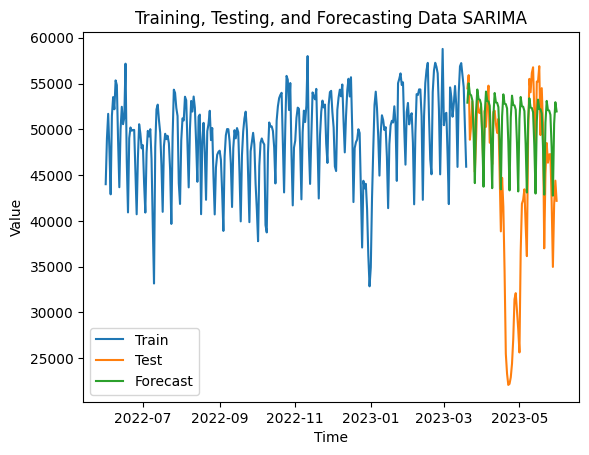

In [25]:
train_normal = df.iloc[:train_size]

start=len(train_normal)
end=len(train_normal)+len(test)-1
pred=model.predict(start=start,end=end,typ='levels')
pred = special.inv_boxcox(pred, lambda_value)
pred = pd.DataFrame(pred)

# Plotting the train and test data
plt.plot(train_normal.index, train_normal, label='Train')
plt.plot(test.index, test, label='Test')
plt.plot(pred.index, pred, label='Forecast')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Training, Testing, and Forecasting Data SARIMA')
plt.show()

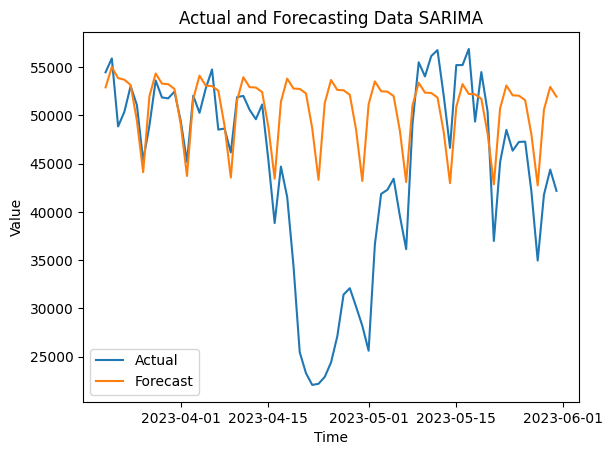

In [26]:
train_normal = df.iloc[:train_size]

start=len(train_normal)
end=len(train_normal)+len(test)-1
pred=model.predict(start=start,end=end,typ='levels')
pred = special.inv_boxcox(pred, lambda_value)
pred = pd.DataFrame(pred)

# Plotting the train and test data
plt.plot(test.index, test, label='Actual')
plt.plot(pred.index, pred, label='Forecast')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Actual and Forecasting Data SARIMA')
plt.show()

In [27]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

pred.rename(columns={'predicted_mean' : 'VOLUME'}, inplace = True)

# Calculate Mean Absolute Deviation (MAD)
mad = mean_absolute_error(test['VOLUME'], pred['VOLUME'])
print("Mean Absolute Deviation (MAD):", mad)

# Calculate Mean Absolute Percentage Error (MAPE)
mape = np.mean(np.abs((test['VOLUME'] - pred['VOLUME']) / test['VOLUME'])) * 100
print("Mean Absolute Percentage Error (MAPE):", mape)

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(test['VOLUME'], pred['VOLUME'])
print("Mean Squared Error (MSE):", mse)

Mean Absolute Deviation (MAD): 7562.334376945288
Mean Absolute Percentage Error (MAPE): 23.81305047064802
Mean Squared Error (MSE): 125398911.05102764


# **PROPHET**

In [28]:
df_prophet=pd.read_csv('DataSARIMAX.csv',sep=';', decimal=',', index_col='DATE', parse_dates=True, dayfirst=True)
pd.set_option('display.float_format', '{:,.2f}'.format)
df_prophet.sort_index(inplace=True)
print(df_prophet.shape)
df_prophet.head()

(365, 4)


,DAY,HOLIDAY,HOLIDAY_NAME,VOLUME
DATE,,,,
2022-06-01,Wednesday,1,Hari Lahir Pancasila,44003.56
2022-06-02,Thursday,0,na,48991.85
2022-06-03,Friday,0,na,51690.92
2022-06-04,Saturday,0,na,47790.83
2022-06-05,Sunday,0,na,42896.64


In [29]:
df_prophet['VOLUME'] = df_prophet['VOLUME'].astype(float)
df_prophet['HOLIDAY'] = df_prophet['HOLIDAY'].astype(int)
print(df_prophet.dtypes)
df_prophet.head()

DAY              object
HOLIDAY           int32
HOLIDAY_NAME     object
VOLUME          float64
dtype: object


,DAY,HOLIDAY,HOLIDAY_NAME,VOLUME
DATE,,,,
2022-06-01,Wednesday,1,Hari Lahir Pancasila,"44,003.56"
2022-06-02,Thursday,0,na,"48,991.85"
2022-06-03,Friday,0,na,"51,690.92"
2022-06-04,Saturday,0,na,"47,790.83"
2022-06-05,Sunday,0,na,"42,896.64"


In [30]:
df_prophet_edit = df_prophet.drop(df_prophet.columns[[0, 1, 2]], axis=1)
df_prophet_edit.reset_index(inplace=True)

df_prophet_edit.rename(columns={'DATE':'ds'}, inplace=True)
df_prophet_edit.rename(columns={'VOLUME':'y'}, inplace=True)

df_prophet_edit

,ds,y
0,2022-06-01,"44,003.56"
1,2022-06-02,"48,991.85"
2,2022-06-03,"51,690.92"
3,2022-06-04,"47,790.83"
4,2022-06-05,"42,896.64"
...,...,...
360,2023-05-27,"42,088.95"
361,2023-05-28,"34,965.85"
362,2023-05-29,"41,785.99"
363,2023-05-30,"44,387.87"


Prophet With Spliting Data Set

In [31]:
# Split the data into train and test sets
train_size = int(len(df_prophet_edit) * 0.8)  # Use 80% of the data for training
train = df_prophet_edit.iloc[:train_size]
test = df_prophet_edit.iloc[train_size:]
print(df_prophet_edit.shape)
print(train.shape,test.shape)

(365, 2)
(292, 2) (73, 2)


In [32]:
m = Prophet(weekly_seasonality = 'auto', seasonality_prior_scale=0.2, 
            changepoint_range=1, changepoint_prior_scale = 0.25)

In [33]:
# Train the model
forecast = m.fit(train)

08:40:24 - cmdstanpy - INFO - Chain [1] start processing
08:40:24 - cmdstanpy - INFO - Chain [1] done processing


In [34]:
future = m.make_future_dataframe(periods=30)
future.tail

<bound method NDFrame.tail of             ds
0   2022-06-01
1   2022-06-02
2   2022-06-03
3   2022-06-04
4   2022-06-05
..         ...
317 2023-04-14
318 2023-04-15
319 2023-04-16
320 2023-04-17
321 2023-04-18

[322 rows x 1 columns]>

In [35]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
317,2023-04-14,"56,234.16","52,482.70","59,987.28"
318,2023-04-15,"51,574.13","47,966.61","55,328.29"
319,2023-04-16,"46,964.04","43,053.31","50,909.37"
320,2023-04-17,"54,464.36","50,639.04","58,521.47"
321,2023-04-18,"56,845.59","52,822.58","60,848.45"


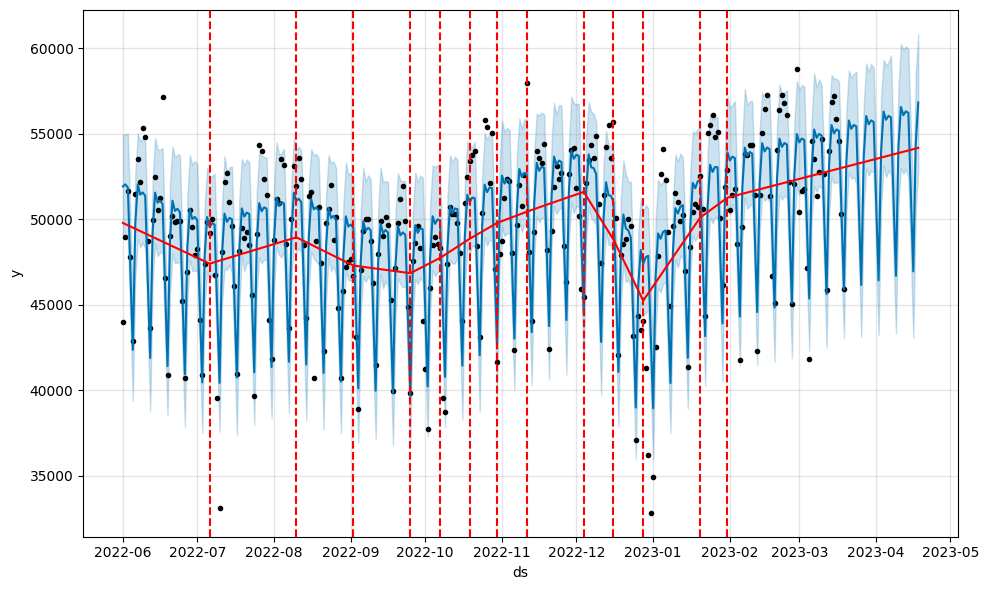

In [36]:
fig1 = m.plot(forecast)
fig1 = add_changepoints_to_plot(fig1.gca(), m, forecast)

prophet with full data set

In [37]:
m = Prophet(weekly_seasonality = True, seasonality_prior_scale=0.1, 
            changepoint_range=1, changepoint_prior_scale = 0.4)

In [38]:
forecast = m.fit(df_prophet_edit)

08:40:26 - cmdstanpy - INFO - Chain [1] start processing
08:40:27 - cmdstanpy - INFO - Chain [1] done processing


In [39]:
future = m.make_future_dataframe(periods=30)
future.tail

<bound method NDFrame.tail of             ds
0   2022-06-01
1   2022-06-02
2   2022-06-03
3   2022-06-04
4   2022-06-05
..         ...
390 2023-06-26
391 2023-06-27
392 2023-06-28
393 2023-06-29
394 2023-06-30

[395 rows x 1 columns]>

In [40]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
390,2023-06-26,"39,973.28","33,339.20","47,038.77"
391,2023-06-27,"42,128.51","35,716.51","49,747.99"
392,2023-06-28,"41,326.93","34,121.63","48,298.99"
393,2023-06-29,"41,274.18","33,865.54","48,637.95"
394,2023-06-30,"41,061.74","34,271.19","49,080.20"


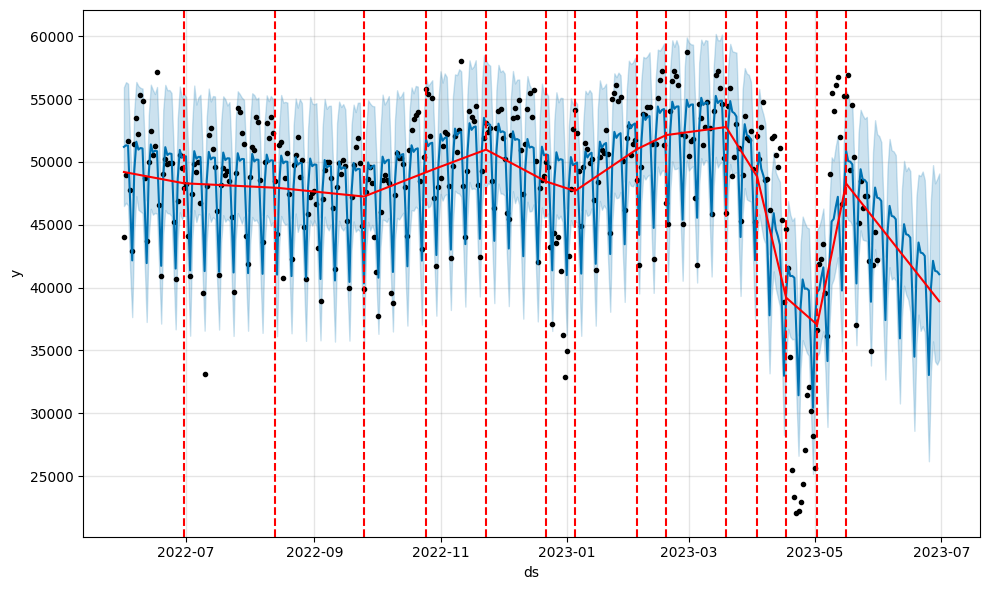

In [41]:
fig1 = m.plot(forecast)
fig1 = add_changepoints_to_plot(fig1.gca(), m, forecast)

prophet with full data set and holiday

In [42]:
holiday_date = df_prophet.copy()
holiday_date.reset_index(inplace=True)
holiday_date = holiday_date.drop(holiday_date.columns[[1,4]], axis=1)
holiday_date = holiday_date[holiday_date['HOLIDAY']!=0]
holiday_date = holiday_date.reset_index(inplace=False)
holiday_date = holiday_date.drop(holiday_date.columns[[0]], axis=1)
holiday_date['HOLIDAY_NAME'] = holiday_date['HOLIDAY_NAME'].str.strip()
holiday_date['HOLIDAY_NAME'] = holiday_date['HOLIDAY_NAME'].str.replace(' ', '_')
holiday_date = holiday_date[holiday_date['HOLIDAY_NAME']!='Imlek']
holiday_date = holiday_date[holiday_date['HOLIDAY_NAME']!='Idul_Fitri']
holiday_date = holiday_date[holiday_date['HOLIDAY_NAME']!='Nyepi']
holiday_date

,DATE,HOLIDAY,HOLIDAY_NAME
0,2022-06-01,1,Hari_Lahir_Pancasila
1,2022-07-09,1,Idul_Adha
2,2022-07-30,1,Tahun_Baru_Islam
3,2022-08-17,1,Hari_Kemerdekaan
4,2022-10-08,1,Maulid_Nabi
5,2022-12-05,1,Natal
6,2023-01-01,1,Tahun_Baru
9,2023-02-18,1,Isra_Mikraj
12,2023-04-07,1,Wafat_Isa_Almasih
20,2023-05-01,1,Hari_Buruh


In [43]:
holiday_date = holiday_date.rename(columns={"DATE":'ds','HOLIDAY_NAME':'holiday'})
holiday_date['ds_upper'] = holiday_date['ds']
holiday_date['lower_window'] = 0
holiday_date['upper_window'] = 1
new_order = ['holiday', 'ds', 'lower_window', 'ds_upper', 'upper_window']
holiday_date =holiday_date[new_order]
holiday_date

,holiday,ds,lower_window,ds_upper,upper_window
0,Hari_Lahir_Pancasila,2022-06-01,0,2022-06-01,1
1,Idul_Adha,2022-07-09,0,2022-07-09,1
2,Tahun_Baru_Islam,2022-07-30,0,2022-07-30,1
3,Hari_Kemerdekaan,2022-08-17,0,2022-08-17,1
4,Maulid_Nabi,2022-10-08,0,2022-10-08,1
5,Natal,2022-12-05,0,2022-12-05,1
6,Tahun_Baru,2023-01-01,0,2023-01-01,1
9,Isra_Mikraj,2023-02-18,0,2023-02-18,1
12,Wafat_Isa_Almasih,2023-04-07,0,2023-04-07,1
20,Hari_Buruh,2023-05-01,0,2023-05-01,1


In [44]:
holiday = pd.DataFrame([
    {'holiday': 'Imlek', 'ds': '2023-01-22', 'lower_window': 0, 'ds_upper': '2023-01-23'},
    {'holiday': 'Nyepi', 'ds': '2023-03-22', 'lower_window': 0, 'ds_upper': '2023-03-23'},
    {'holiday': 'Idul_Fitri', 'ds': '2023-04-19', 'lower_window': 0, 'ds_upper': '2023-04-25'},
])

for t_col in ['ds', 'ds_upper']:
    holiday[t_col] = pd.to_datetime(holiday[t_col])
holiday['upper_window'] = ((holiday['ds_upper'] - holiday['ds'])).dt.days + 1
holiday

,holiday,ds,lower_window,ds_upper,upper_window
0,Imlek,2023-01-22,0,2023-01-23,2
1,Nyepi,2023-03-22,0,2023-03-23,2
2,Idul_Fitri,2023-04-19,0,2023-04-25,7


In [45]:
holiday = pd.concat([holiday, holiday_date])
holiday = holiday.sort_values('ds')
holiday

,holiday,ds,lower_window,ds_upper,upper_window
0,Hari_Lahir_Pancasila,2022-06-01,0,2022-06-01,1
1,Idul_Adha,2022-07-09,0,2022-07-09,1
2,Tahun_Baru_Islam,2022-07-30,0,2022-07-30,1
3,Hari_Kemerdekaan,2022-08-17,0,2022-08-17,1
4,Maulid_Nabi,2022-10-08,0,2022-10-08,1
5,Natal,2022-12-05,0,2022-12-05,1
6,Tahun_Baru,2023-01-01,0,2023-01-01,1
0,Imlek,2023-01-22,0,2023-01-23,2
9,Isra_Mikraj,2023-02-18,0,2023-02-18,1
1,Nyepi,2023-03-22,0,2023-03-23,2


In [46]:
df_no_outlier = df_prophet_edit.copy()
df_no_outlier.loc[(df_no_outlier['ds'] >= '2023-04-19') & (df_no_outlier['ds'] <= '2023-05-03'), 'y'] = None

filtered_df = df_no_outlier.loc[(df_no_outlier['ds'] >= '2023-04-19') & (df_no_outlier['ds'] <= '2023-05-03')]
filtered_df

,ds,y
322,2023-04-19,NaN
323,2023-04-20,NaN
324,2023-04-21,NaN
325,2023-04-22,NaN
326,2023-04-23,NaN
327,2023-04-24,NaN
328,2023-04-25,NaN
329,2023-04-26,NaN
330,2023-04-27,NaN
331,2023-04-28,NaN


In [47]:
m = Prophet(weekly_seasonality = 'auto', seasonality_prior_scale=0.2, 
            changepoint_range=1, changepoint_prior_scale = 0.25,
            holidays=holiday)


In [48]:
forecast = m.fit(df_prophet_edit)

08:40:29 - cmdstanpy - INFO - Chain [1] start processing
08:40:30 - cmdstanpy - INFO - Chain [1] done processing


In [49]:
future = m.make_future_dataframe(periods=30)
future.tail

<bound method NDFrame.tail of             ds
0   2022-06-01
1   2022-06-02
2   2022-06-03
3   2022-06-04
4   2022-06-05
..         ...
390 2023-06-26
391 2023-06-27
392 2023-06-28
393 2023-06-29
394 2023-06-30

[395 rows x 1 columns]>

In [50]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
390,2023-06-26,"46,602.49","42,300.11","50,666.88"
391,2023-06-27,"48,754.96","44,710.94","53,027.72"
392,2023-06-28,"48,699.80","44,604.57","52,738.30"
393,2023-06-29,"48,301.59","44,169.81","52,571.23"
394,2023-06-30,"48,150.31","44,329.21","52,590.57"


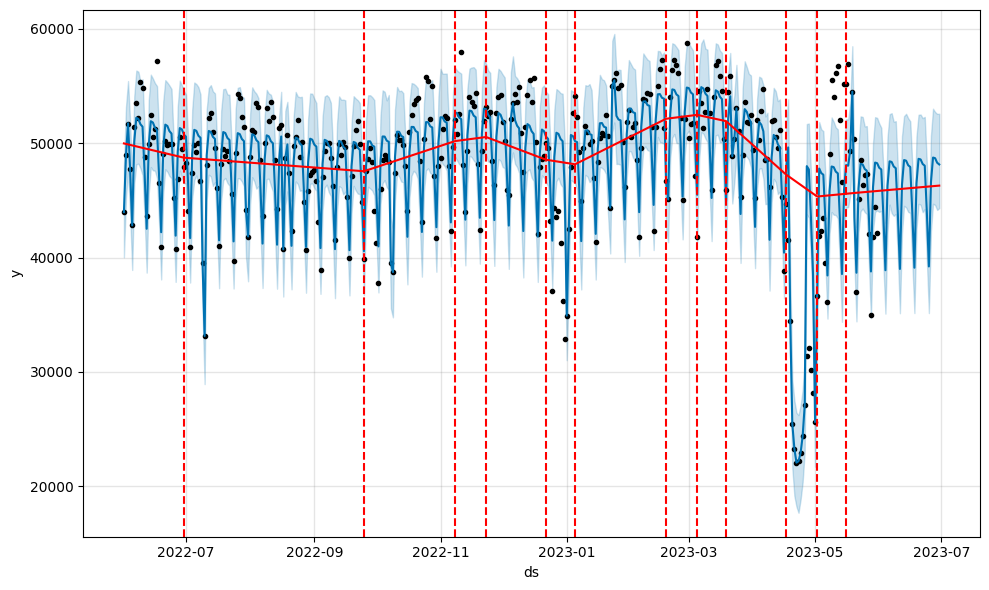

In [51]:
fig1 = m.plot(forecast)
fig1 = add_changepoints_to_plot(fig1.gca(), m, forecast)

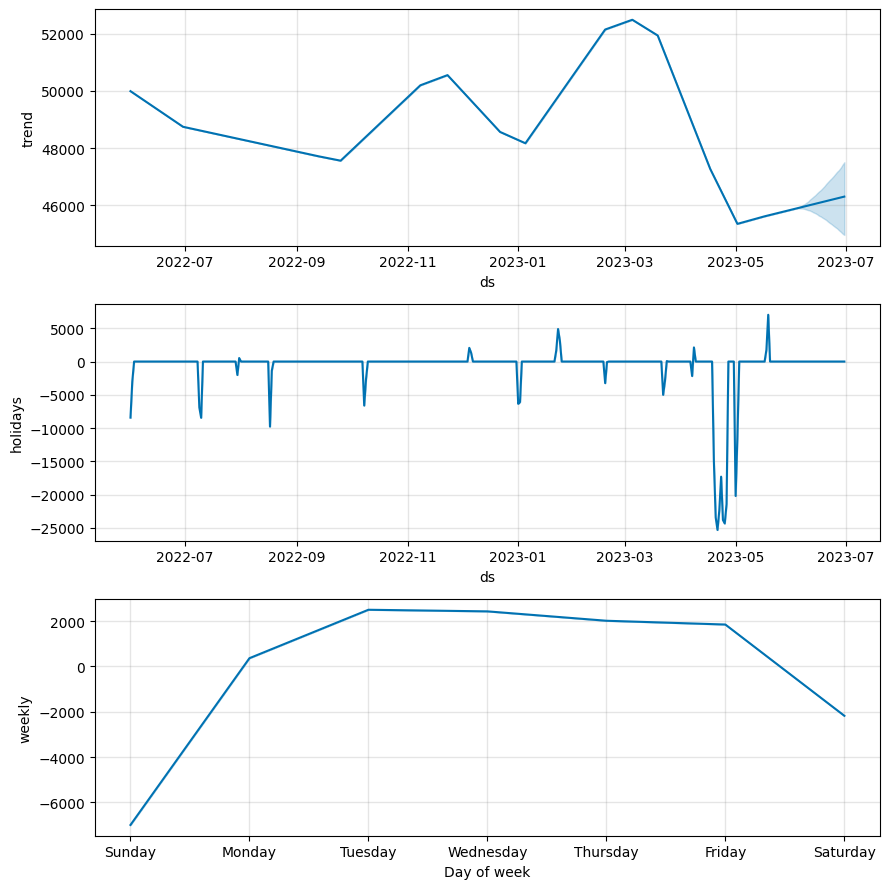

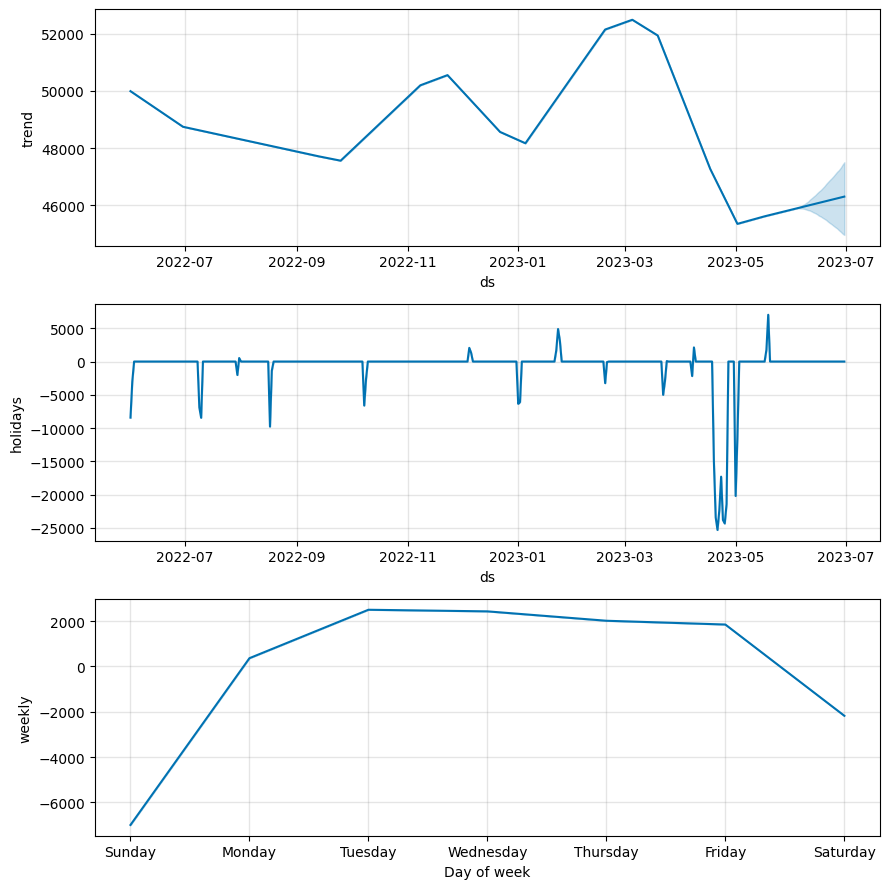

In [52]:
m.plot_components(forecast)

Foreast Result for June 2023

In [53]:
forecast_result = forecast[['ds', 'yhat']]
forecast_result.rename(columns={'ds':'DATE','yhat':'FORECAST'}, inplace=True)
forecast_result['DATE'] = pd.to_datetime(forecast_result['DATE'])
forecast_result.set_index('DATE', inplace = True)
forecast_result

C:\Users\rizki\AppData\Local\Temp\ipykernel_11292\2427669168.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forecast_result.rename(columns={'ds':'DATE','yhat':'FORECAST'}, inplace=True)
C:\Users\rizki\AppData\Local\Temp\ipykernel_11292\2427669168.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forecast_result['DATE'] = pd.to_datetime(forecast_result['DATE'])


,FORECAST
DATE,
2022-06-01,"43,988.56"
2022-06-02,"48,974.47"
2022-06-03,"51,754.38"
2022-06-04,"47,686.66"
2022-06-05,"42,824.46"
...,...
2023-06-26,"46,602.49"
2023-06-27,"48,754.96"
2023-06-28,"48,699.80"


In [54]:
df_volume = df_prophet.drop(df_prophet.columns[[0,1,2]], axis=1)
df_volume.rename(columns={'VOLUME':'ACTUAL'}, inplace=True)
df_volume

,ACTUAL
DATE,
2022-06-01,"44,003.56"
2022-06-02,"48,991.85"
2022-06-03,"51,690.92"
2022-06-04,"47,790.83"
2022-06-05,"42,896.64"
...,...
2023-05-27,"42,088.95"
2023-05-28,"34,965.85"
2023-05-29,"41,785.99"


In [55]:
actual_vs_forecast = forecast_result.loc[(forecast_result.index >= '2022-06-01') 
                                         & (forecast_result.index <= '2023-05-31')]
actual_vs_forecast = actual_vs_forecast.join(df_volume)
actual_vs_forecast

,FORECAST,ACTUAL
DATE,,
2022-06-01,"43,988.56","44,003.56"
2022-06-02,"48,974.47","48,991.85"
2022-06-03,"51,754.38","51,690.92"
2022-06-04,"47,686.66","47,790.83"
2022-06-05,"42,824.46","42,896.64"
...,...,...
2023-05-27,"43,592.35","42,088.95"
2023-05-28,"38,788.81","34,965.85"
2023-05-29,"46,163.35","41,785.99"


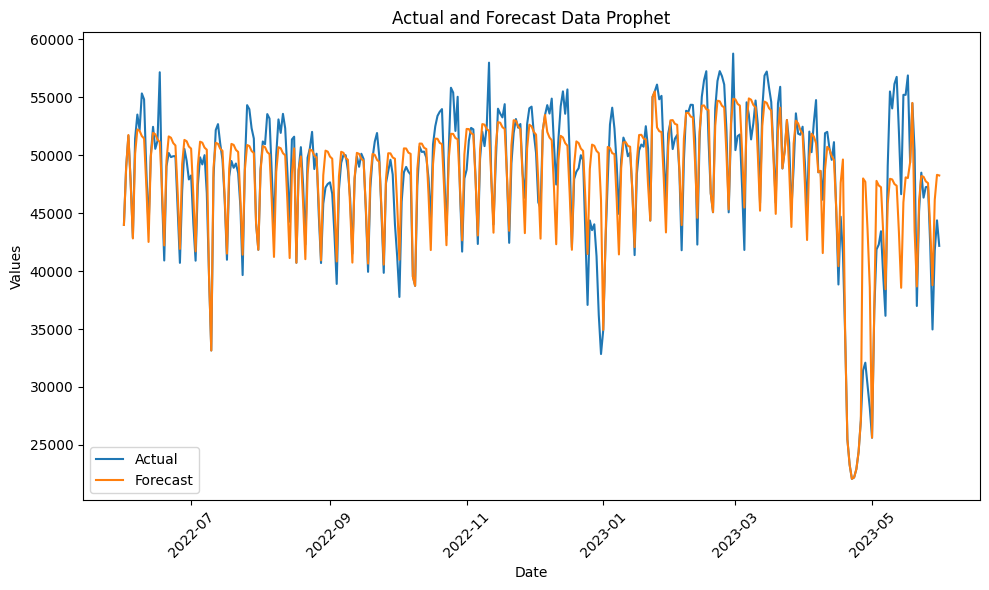

In [56]:
import matplotlib.pyplot as plt

# Create the line plot
plt.figure(figsize=(10, 6))
plt.plot(actual_vs_forecast.index, actual_vs_forecast['ACTUAL'], label='Actual')
plt.plot(actual_vs_forecast.index, actual_vs_forecast['FORECAST'], label='Forecast')

plt.xlabel('Date')
plt.ylabel('Values')
plt.title('Actual and Forecast Data Prophet')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Forecast Accuracy

In [57]:
# Split the data into train and test sets
train_size = int(len(actual_vs_forecast) * 0.8) 
train = actual_vs_forecast.iloc[:train_size]
test = actual_vs_forecast.iloc[train_size:]
print(actual_vs_forecast.shape)
print(train.shape,test.shape)

(365, 2)
(292, 2) (73, 2)


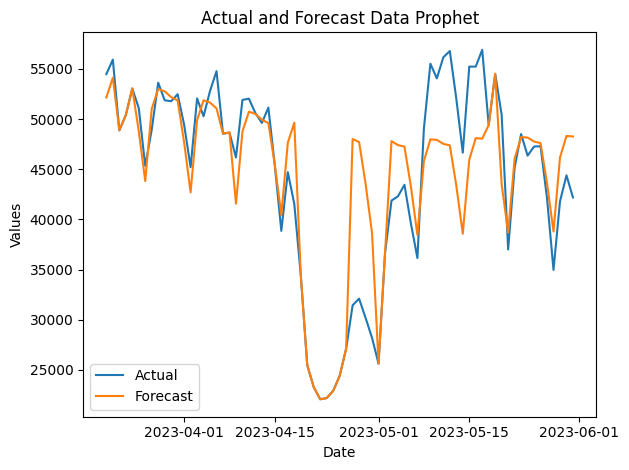

In [58]:
# Create the line plot
# plt.figure(figsize=(10, 6))
plt.plot(test.index, test['ACTUAL'], label='Actual')
plt.plot(test.index, test['FORECAST'], label='Forecast')

plt.xlabel('Date')
plt.ylabel('Values')
plt.title('Actual and Forecast Data Prophet')
plt.legend()
# plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [59]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Calculate Mean Absolute Deviation (MAD)
mad = mean_absolute_error(test['ACTUAL'], test['FORECAST'])
print("Mean Absolute Deviation (MAD):", mad)

# Calculate Mean Absolute Percentage Error (MAPE)
mape = np.mean(np.abs((test['ACTUAL'] - test['FORECAST']) / test['FORECAST'])) * 100
print("Mean Absolute Percentage Error (MAPE):", mape)

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(test['ACTUAL'], test['FORECAST'])
print("Mean Squared Error (MSE):", mse)

Mean Absolute Deviation (MAD): 3220.7791733003346
Mean Absolute Percentage Error (MAPE): 7.022401936014411
Mean Squared Error (MSE): 25109181.534142923


### Prophet Holiday Tuning With Extended Holiday

In [60]:
holiday_date = df_prophet.copy()
holiday_date.reset_index(inplace=True)
holiday_date = holiday_date.drop(holiday_date.columns[[1,4]], axis=1)
holiday_date = holiday_date[holiday_date['HOLIDAY']!=0]
holiday_date = holiday_date.reset_index(inplace=False)
holiday_date = holiday_date.drop(holiday_date.columns[[0]], axis=1)
holiday_date['HOLIDAY_NAME'] = holiday_date['HOLIDAY_NAME'].str.strip()
holiday_date['HOLIDAY_NAME'] = holiday_date['HOLIDAY_NAME'].str.replace(' ', '_')
holiday_date = holiday_date[holiday_date['HOLIDAY_NAME']!='Imlek']
holiday_date = holiday_date[holiday_date['HOLIDAY_NAME']!='Idul_Fitri']
holiday_date = holiday_date[holiday_date['HOLIDAY_NAME']!='Nyepi']
holiday_date

,DATE,HOLIDAY,HOLIDAY_NAME
0,2022-06-01,1,Hari_Lahir_Pancasila
1,2022-07-09,1,Idul_Adha
2,2022-07-30,1,Tahun_Baru_Islam
3,2022-08-17,1,Hari_Kemerdekaan
4,2022-10-08,1,Maulid_Nabi
5,2022-12-05,1,Natal
6,2023-01-01,1,Tahun_Baru
9,2023-02-18,1,Isra_Mikraj
12,2023-04-07,1,Wafat_Isa_Almasih
20,2023-05-01,1,Hari_Buruh


In [61]:
holiday_date = holiday_date.rename(columns={"DATE":'ds','HOLIDAY_NAME':'holiday'})
holiday_date['ds_upper'] = holiday_date['ds']
holiday_date['lower_window'] = 0
holiday_date['upper_window'] = 1
new_order = ['holiday', 'ds', 'lower_window', 'ds_upper', 'upper_window']
holiday_date =holiday_date[new_order]
holiday_date

,holiday,ds,lower_window,ds_upper,upper_window
0,Hari_Lahir_Pancasila,2022-06-01,0,2022-06-01,1
1,Idul_Adha,2022-07-09,0,2022-07-09,1
2,Tahun_Baru_Islam,2022-07-30,0,2022-07-30,1
3,Hari_Kemerdekaan,2022-08-17,0,2022-08-17,1
4,Maulid_Nabi,2022-10-08,0,2022-10-08,1
5,Natal,2022-12-05,0,2022-12-05,1
6,Tahun_Baru,2023-01-01,0,2023-01-01,1
9,Isra_Mikraj,2023-02-18,0,2023-02-18,1
12,Wafat_Isa_Almasih,2023-04-07,0,2023-04-07,1
20,Hari_Buruh,2023-05-01,0,2023-05-01,1


In [62]:
# Python
holiday = pd.DataFrame([
    {'holiday': 'Imlek', 'ds': '2023-01-22', 'lower_window': 0, 'ds_upper': '2023-01-23'},
    {'holiday': 'Nyepi', 'ds': '2023-03-22', 'lower_window': 0, 'ds_upper': '2023-03-23'},
    {'holiday': 'Idul_Fitri', 'ds': '2023-04-19', 'lower_window': 0, 'ds_upper': '2023-04-25'},
])

for t_col in ['ds', 'ds_upper']:
    holiday[t_col] = pd.to_datetime(holiday[t_col])
holiday['upper_window'] = ((holiday['ds_upper'] - holiday['ds'])).dt.days + 1
holiday

,holiday,ds,lower_window,ds_upper,upper_window
0,Imlek,2023-01-22,0,2023-01-23,2
1,Nyepi,2023-03-22,0,2023-03-23,2
2,Idul_Fitri,2023-04-19,0,2023-04-25,7


In [63]:
holiday = pd.concat([holiday, holiday_date])
holiday = holiday.sort_values('ds')
holiday.loc[holiday['holiday'] == 'Idul_Fitri', 'upper_window'] = 12
holiday.loc[holiday['holiday'] == 'Idul_Fitri', 'ds_upper'] = pd.to_datetime("2023-04-30")
holiday

,holiday,ds,lower_window,ds_upper,upper_window
0,Hari_Lahir_Pancasila,2022-06-01,0,2022-06-01,1
1,Idul_Adha,2022-07-09,0,2022-07-09,1
2,Tahun_Baru_Islam,2022-07-30,0,2022-07-30,1
3,Hari_Kemerdekaan,2022-08-17,0,2022-08-17,1
4,Maulid_Nabi,2022-10-08,0,2022-10-08,1
5,Natal,2022-12-05,0,2022-12-05,1
6,Tahun_Baru,2023-01-01,0,2023-01-01,1
0,Imlek,2023-01-22,0,2023-01-23,2
9,Isra_Mikraj,2023-02-18,0,2023-02-18,1
1,Nyepi,2023-03-22,0,2023-03-23,2


In [64]:
m = Prophet(weekly_seasonality = 'auto', seasonality_prior_scale=0.01,
            changepoint_range=1, changepoint_prior_scale = 0.02, 
             holidays=holiday)


In [65]:
forecast = m.fit(df_prophet_edit)

08:40:36 - cmdstanpy - INFO - Chain [1] start processing
08:40:36 - cmdstanpy - INFO - Chain [1] done processing


In [66]:
future = m.make_future_dataframe(periods=30)
future.tail

<bound method NDFrame.tail of             ds
0   2022-06-01
1   2022-06-02
2   2022-06-03
3   2022-06-04
4   2022-06-05
..         ...
390 2023-06-26
391 2023-06-27
392 2023-06-28
393 2023-06-29
394 2023-06-30

[395 rows x 1 columns]>

In [67]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
390,2023-06-26,"48,354.06","44,592.67","52,164.89"
391,2023-06-27,"50,104.86","46,150.00","54,016.79"
392,2023-06-28,"49,979.33","46,001.71","53,845.13"
393,2023-06-29,"49,973.05","45,777.29","54,041.32"
394,2023-06-30,"49,812.94","46,146.06","53,705.19"


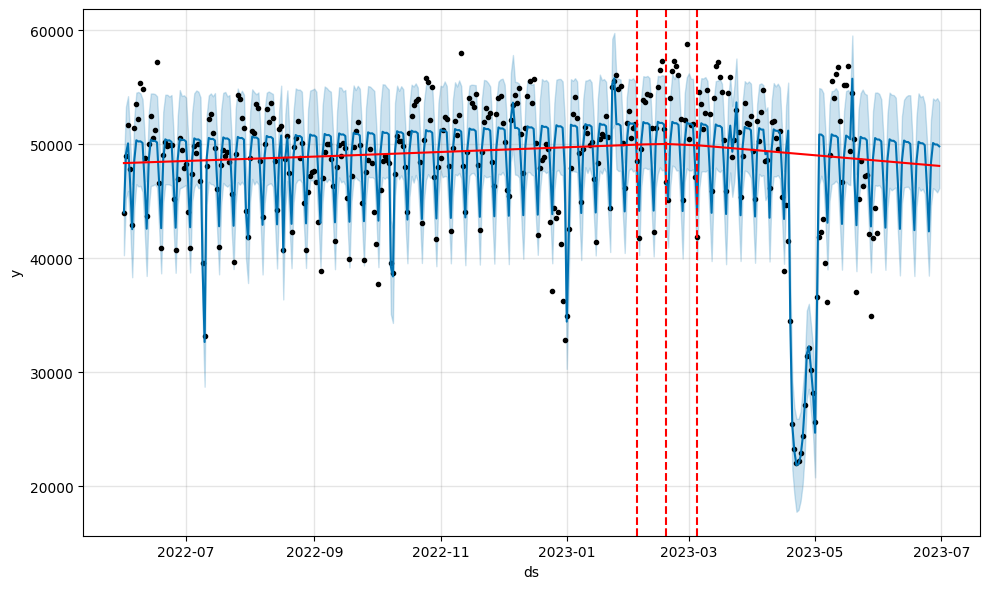

In [68]:
fig1 = m.plot(forecast)
fig1 = add_changepoints_to_plot(fig1.gca(), m, forecast)

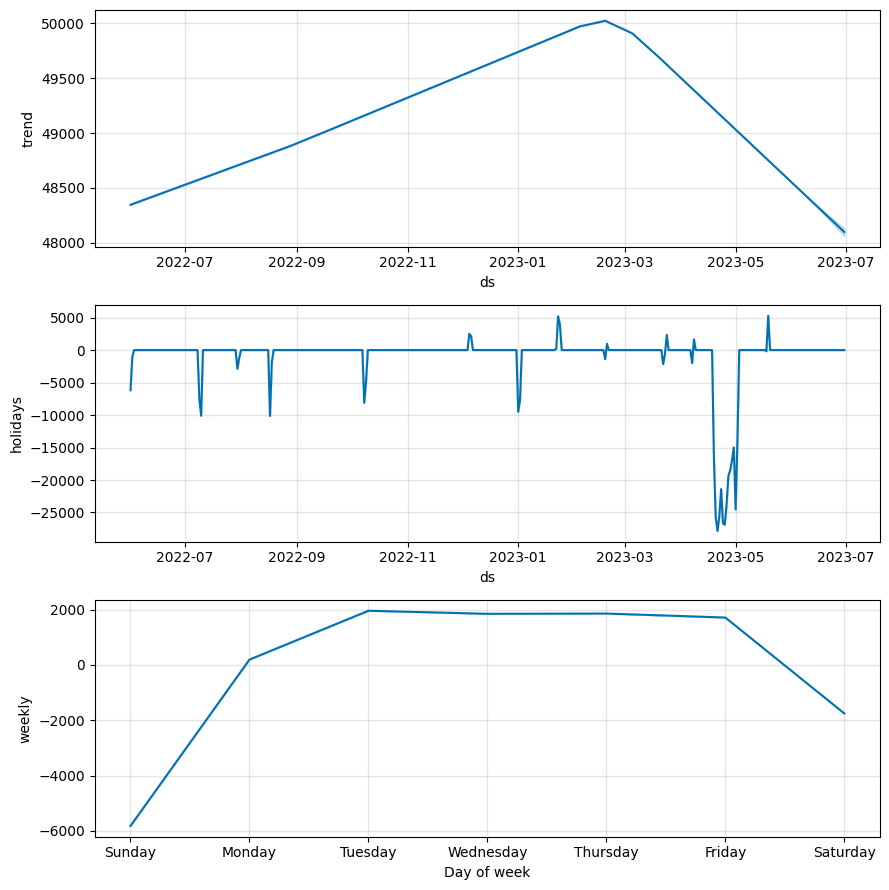

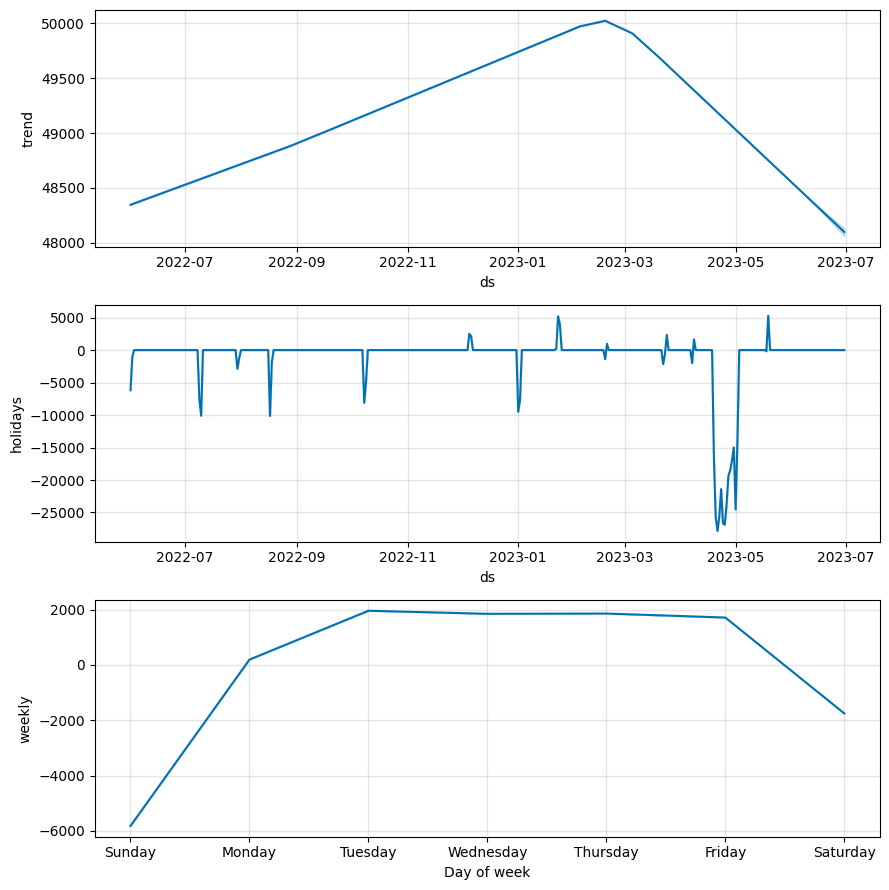

In [69]:
m.plot_components(forecast)

C:\Users\rizki\AppData\Local\Temp\ipykernel_11292\1324482126.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forecast_result.rename(columns={'ds':'DATE','yhat':'FORECAST'}, inplace=True)
C:\Users\rizki\AppData\Local\Temp\ipykernel_11292\1324482126.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forecast_result['DATE'] = pd.to_datetime(forecast_result['DATE'])


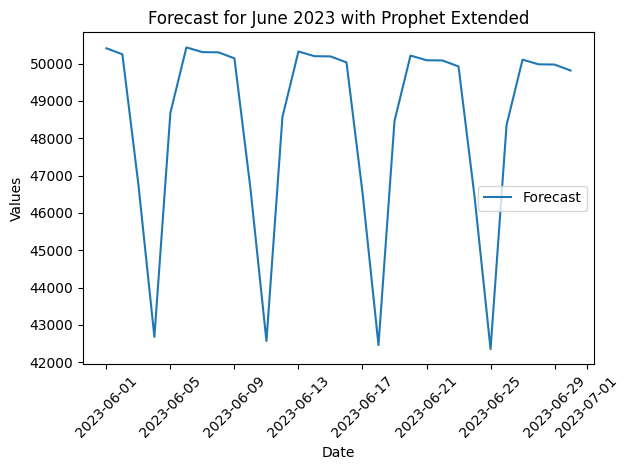

In [70]:
forecast_result = forecast[['ds', 'yhat']]
forecast_result.rename(columns={'ds':'DATE','yhat':'FORECAST'}, inplace=True)
forecast_result['DATE'] = pd.to_datetime(forecast_result['DATE'])
forecast_result.set_index('DATE', inplace = True)

forecast_june_2023 = forecast_result.loc[(forecast_result.index >= '2023-06-01') 
                                         & (forecast_result.index <= '2023-06-30')]

plt.plot(forecast_june_2023.index, forecast_june_2023['FORECAST'], label='Forecast')

plt.xlabel('Date')
plt.ylabel('Values')
plt.title('Forecast for June 2023 with Prophet Extended')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

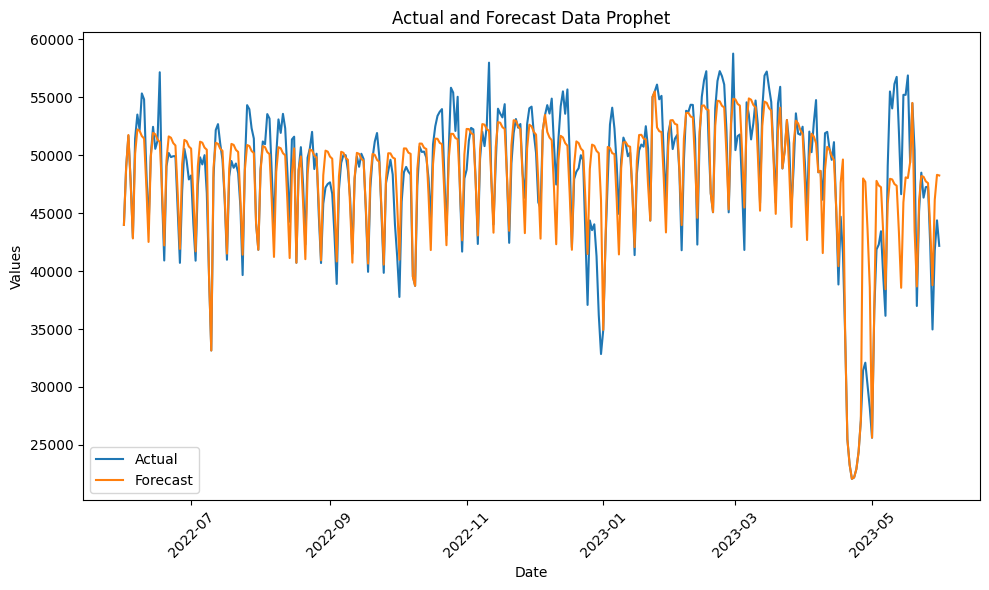

In [71]:
# Create the line plot
plt.figure(figsize=(10, 6))
plt.plot(actual_vs_forecast.index, actual_vs_forecast['ACTUAL'], label='Actual')
plt.plot(actual_vs_forecast.index, actual_vs_forecast['FORECAST'], label='Forecast')

plt.xlabel('Date')
plt.ylabel('Values')
plt.title('Actual and Forecast Data Prophet')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

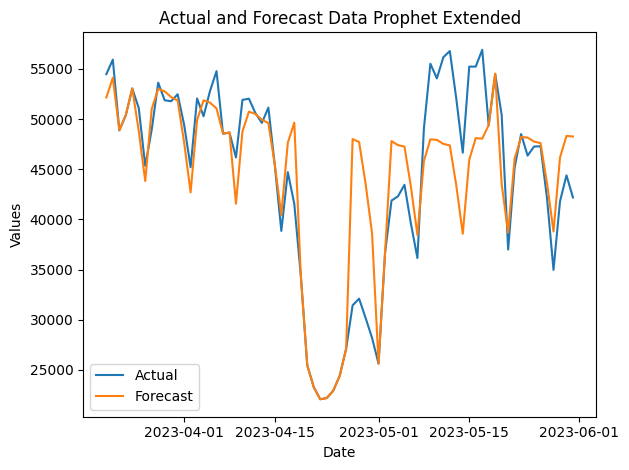

In [72]:
# Create the line plot
# plt.figure(figsize=(10, 6))
plt.plot(test.index, test['ACTUAL'], label='Actual')
plt.plot(test.index, test['FORECAST'], label='Forecast')

plt.xlabel('Date')
plt.ylabel('Values')
plt.title('Actual and Forecast Data Prophet Extended')
plt.legend()
# plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [73]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Calculate Mean Absolute Deviation (MAD)
mad = mean_absolute_error(test['ACTUAL'], test['FORECAST'])
print("Mean Absolute Deviation (MAD):", mad)

# Calculate Mean Absolute Percentage Error (MAPE)
mape = np.mean(np.abs((test['ACTUAL'] - test['FORECAST']) / test['FORECAST'])) * 100
print("Mean Absolute Percentage Error (MAPE):", mape)

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(test['ACTUAL'], test['FORECAST'])
print("Mean Squared Error (MSE):", mse)

Mean Absolute Deviation (MAD): 3220.7791733003346
Mean Absolute Percentage Error (MAPE): 7.022401936014411
Mean Squared Error (MSE): 25109181.534142923
